In [1]:
#importing necessary packages
# ---------------------------------------------------------
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
from scipy.stats import ttest_ind

# from statsmodels.formula.api import ols

from sklearn.ensemble import VotingClassifier
sys.path.append('/home/ackmanadmin/Documents/pywholebrain')
from hdf5manager import hdf5manager as h5
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.style.use('publication')
plt.rcParams['font.size'] = 8

save = False

ModuleNotFoundError: No module named 'hdf5manager'

In [4]:
wd = '../../'
# wd = '/home/brian/Documents/data/Classifier/expMetrics/'

data = pd.read_csv('../../training_dataset_update_OB.tsv', sep=',', index_col='exp_ic')
# novel['train'] = 0
# training['train'] = 1
# data = novel.append(training)
data = data.sort_index()
data = data.fillna(0)
print(data.head())
j=-1
current = 'Nope'
for i, ind in enumerate(data.index):
    if ind[:12]==current:
        data.loc[ind,'anml']=j
    else:
        j+=1
        data.loc[ind,'anml']=j
        current=ind[:12]
print(len(data))

#renaming the columns
neural_dict = {}

for col in data.columns:
    if "." in col:
        new_col = col.replace(".", "_")
        neural_dict[col] = new_col

data = data.rename(columns=neural_dict)

dataNoThresh = data[data['threshold_area'] == 0].copy()

dataThresh = data[data['threshold_area'] != 0].copy()

print('Full dataset: ', len(data))
print('Those with threshold: ', len(dataThresh))
print('Those without threshold: ', len(dataNoThresh))

                   age  freq.avgsnr  freq.integrate  freq.maxsnr  \
exp_ic                                                             
190408_03-04-0000   22     1.193897        0.006304     1.327806   
190408_03-04-0001   22     1.422100        0.120683     1.620314   
190408_03-04-0002   22     1.296523        0.107689     1.513039   
190408_03-04-0003   22     1.172093        0.179745     1.306229   
190408_03-04-0004   22     2.093038        0.589769     3.606708   

                   freq.maxsnr.freq  freq.range.high  freq.range.low  \
exp_ic                                                                 
190408_03-04-0000          4.204482         4.585020        2.973018   
190408_03-04-0001          4.585020         0.005325        0.004883   
190408_03-04-0002          4.585020         0.005325        0.004883   
190408_03-04-0003          2.973018         0.963882        0.371627   
190408_03-04-0004          3.242099         0.007530        0.004883   

                  

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state=42)

droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 
            'mass_perc', 'mass_region','mass_total', 'hemodynamic', 'movement']
try:
    X = data.drop(droplist, axis=1).fillna(value=0).copy()
except Exception as e:
    X = data.fillna(value=0).copy()
    print(e)
    
data_final_vars = X.columns.values.tolist()    
scaler.fit(X.values)
X[:] = scaler.transform(X.values)
y = data['signal'].copy()

rfe = RFE(rnd_clf, 20)
rfe = rfe.fit(X.values, y.values.ravel())

print('Support\tRanking\tVariable')
for i, var in enumerate(data_final_vars):
    print(rfe.support_[i], '\t',rfe.ranking_[i],'\t', var)

new_vars = X.columns.values[rfe.ranking_ == 1].tolist()
# new_vars.append('class')
print(new_vars)

Support	Ranking	Variable
False 	 13 	 freq_avgsnr
False 	 7 	 freq_integrate
False 	 11 	 freq_maxsnr
False 	 10 	 freq_maxsnr_freq
True 	 1 	 freq_range_high
True 	 1 	 freq_range_low
True 	 1 	 freq_rangesz
True 	 1 	 region_centroid_0
True 	 1 	 region_centroid_1
True 	 1 	 region_eccentricity
True 	 1 	 region_extent
True 	 1 	 region_majaxis
True 	 1 	 region_majmin_ratio
True 	 1 	 region_minaxis
False 	 9 	 region_orient
False 	 8 	 spatial_COMall_x
False 	 4 	 spatial_COMall_y
False 	 12 	 spatial_avg
True 	 1 	 spatial_max
True 	 1 	 spatial_min
False 	 2 	 spatial_n_domains
False 	 5 	 spatial_std
False 	 6 	 temporal_autocorr
True 	 1 	 temporal_max
True 	 1 	 temporal_min
False 	 15 	 temporal_n_freq
True 	 1 	 temporal_std
True 	 1 	 threshold_area
True 	 1 	 threshold_perc
True 	 1 	 move_corr
False 	 14 	 res
False 	 16 	 train
True 	 1 	 class
False 	 3 	 var_pos
True 	 1 	 rel_pos
['freq_range_high', 'freq_range_low', 'freq_rangesz', 'region_centroid_0', 'region_centro

In [6]:
rnd_clf.fit(X.values, y.values)
feat_imp = rnd_clf.feature_importances_


In [10]:
spatiallist = ['move_corr','spatial_COMall_x', 'spatial_COMall_y', 'spatial_avg', 'spatial_max',
             'spatial_min', 'spatial_n_domains', 'spatial_std']
morphlist = ['region_centroid_0', 'region_centroid_1', 'region_eccentricity', 
             'region_extent','region_majaxis', 'region_majmin_ratio', 'region_minaxis',
             'region_orient',  'threshold_area', 'threshold_perc']
temporallist = ['temporal_autocorr','temporal_max', 'temporal_min', 'temporal_n_freq', 
                'temporal_std']
freqlist = ['freq_avgsnr', 'freq_integrate', 'freq_maxsnr','freq_maxsnr_freq', 
            'freq_range_high', 'freq_range_low', 'freq_rangesz']


print(data.columns)
droplist = ['age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
dcorr = data.drop(droplist, axis=1)
dcorr = dcorr.drop(['artifact', 'signal'], axis=1).corrwith(data['signal'],method='pearson')

sort = dcorr.sort_values(ascending=False)
t = np.concatenate((sort[:,None],sort[:,None]), axis=1)
sdata = t[sort.index.isin(spatiallist)]
mdata = t[sort.index.isin(morphlist)]
tdata = t[sort.index.isin(temporallist)]
fdata = t[sort.index.isin(freqlist)]


Index(['age', 'freq_avgsnr', 'freq_integrate', 'freq_maxsnr',
       'freq_maxsnr_freq', 'freq_range_high', 'freq_range_low', 'freq_rangesz',
       'length', 'mass_perc', 'mass_region', 'mass_total', 'region_centroid_0',
       'region_centroid_1', 'region_eccentricity', 'region_extent',
       'region_majaxis', 'region_majmin_ratio', 'region_minaxis',
       'region_orient', 'signal', 'spatial_COMall_x', 'spatial_COMall_y',
       'spatial_COMdom_x', 'spatial_COMdom_y', 'spatial_avg', 'spatial_max',
       'spatial_min', 'spatial_n_domains', 'spatial_std', 'temporal_autocorr',
       'temporal_max', 'temporal_min', 'temporal_n_freq', 'temporal_std',
       'threshold_area', 'threshold_perc', 'anml', 'artifact', 'hemodynamic',
       'movement', 'move_corr', 'res', 'train', 'class', 'var_pos', 'rel_pos'],
      dtype='object')


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[~np.isnan(data)])
dataAll = data.copy()
dataAll[:] = scaler.transform(dataAll[~np.isnan(data)].values)
def populationModeDiff(vector1, vector2, bins = 25):
    hist, bin_edges = np.histogram(vector1, bins= bins)
    hist2, bin_edges2 = np.histogram(vector2, bins= bins)
    return bin_edges[np.argmax(hist)] - bin_edges2[np.argmax(hist2)]

sdata_mode = np.zeros(sdata.shape[0])
mdata_mode = np.zeros(mdata.shape[0])
tdata_mode = np.zeros(tdata.shape[0])
fdata_mode = np.zeros(fdata.shape[0])

sdata_median = np.zeros(sdata.shape[0])
mdata_median = np.zeros(mdata.shape[0])
tdata_median = np.zeros(tdata.shape[0])
fdata_median = np.zeros(fdata.shape[0])


for i, met in enumerate(spatiallist):
    sdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(morphlist):
    mdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(temporallist):
    tdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(freqlist):
    fdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
    
# for i, met in enumerate(spatiallist):
#     sdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(morphlist):
#     mdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(temporallist):
#     tdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(freqlist):
#     fdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
    

# Scatter plot for feature selection metrics

spatial_min 34.18337875119486
move_corr -22.653160743913933
spatial_max -28.21001848113342
region_minaxis 50.82000795405193
threshold_area 44.85861690631976
region_extent 28.587356695728786
threshold_perc 26.702791312769225
region_majaxis 23.4087662480039
region_majmin_ratio -12.175538443142438
temporal_min -15.885730020754833
freq_rangesz 41.87241525409324
['spatial_min', 'move_corr', 'spatial_max', 'region_minaxis', 'threshold_area', 'region_extent', 'threshold_perc', 'region_majaxis', 'region_majmin_ratio', 'temporal_min', 'freq_rangesz']
3 0.30812070483489473 spatial_max
4 0.2272754190214517 spatial_min
18 0.025304619847138776 move_corr
19 0.021894413856830497 spatial_n_domains
23 0.012043743550374153 spatial_std
24 0.011780142079980805 spatial_COMall_y
26 0.010404633962948688 spatial_COMall_x
31 0.0054477623470422275 spatial_avg
1 0.4756726025056147 region_minaxis
2 0.3583474294347253 threshold_area
5 0.1604390311573386 region_majaxis
6 0.14844182649421936 region_extent
9 0.083839

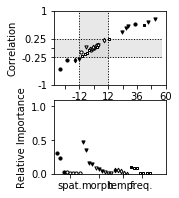

In [12]:
fig, axs = plt.subplots(2,1, figsize=(2,3))




domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

cmap = plt.cm.get_cmap('Reds')

max_feature_imp = np.nanmax(rnd_clf.feature_importances_)
markersize = 10
markersize2 = 7

fulllist = []

tstatcutt = 12
corrcutt = 0.25
diffcutt = 2.5

end = np.zeros(4)

k = 0

sort_import = np.sort(rnd_clf.feature_importances_)[::-1]
argsort_import = np.argsort(rnd_clf.feature_importances_, )[::-1]
# print(data_final_vars[argsort_import])
rownames = sort.index[sort.index.isin(spatiallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
        if row == var:
            if (np.abs(sdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(sdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, sdata[i,0], marker="o",s=markersize, 
                             c='k', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(tstat, sdata[i,0], marker="o",s=markersize, 
                             c='w', edgecolors = 'k', linewidth = 1)
                
rownames = sort.index[sort.index.isin(morphlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if row == 'region_minaxis':
                pvalue = 10**(-320)
            if (np.abs(mdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(mdata_mode[i]) > diffcutt):
                print(row, tstat)                
                fulllist.append(row)            
                axs[0].scatter(tstat, mdata[i,0], marker="v",s=markersize,
                             c='k', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
            else:
                axs[0].scatter(tstat, mdata[i,0], marker="v",s=markersize,
                             c='w', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
        
rownames = sort.index[sort.index.isin(temporallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(tdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(tdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, tdata[i,0], marker="d",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)             
            else:
                axs[0].scatter(tstat, tdata[i,0], marker="d",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)             
        
rownames = sort.index[sort.index.isin(freqlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(fdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(fdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, fdata[i,0], marker="s",s=markersize2,
                            c='k', edgecolors = 'k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            linewidth = 1)
            else:
                axs[0].scatter(tstat, fdata[i,0], marker="s",s=markersize2,
                            c='w',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            edgecolors = 'k', linewidth = 1)

print(fulllist)                
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in spatiallist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[0]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in morphlist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[1]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in temporallist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[2]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in freqlist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[3]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
        
axs[0].set_ylabel('Correlation')
axs[0].set_ylim([-1,1])
axs[0].set_yticks([-1,-corrcutt, 0, corrcutt, 1])
axs[0].set_yticklabels(['-1','-{}'.format(corrcutt),'', '{}'.format(corrcutt), '1'])

lims = axs[0].get_xlim()
axs[0].fill_between(lims, [corrcutt,corrcutt], [-corrcutt,-corrcutt], color = 'lightgrey', alpha=0.5, zorder=0)
axs[0].hlines(corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].hlines(-corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].axvspan(-tstatcutt,tstatcutt, color = 'lightgrey', alpha=0.5, zorder=0)
axs[0].vlines(tstatcutt, ymin=-1, ymax=1, linewidth=1, linestyle=':')
axs[0].vlines(-tstatcutt, ymin=-1, ymax=1, linewidth=1, linestyle=':')


axs[0].set_xlim(lims)
axs[0].set_xticks([-2*tstatcutt,-tstatcutt,0,tstatcutt,2*tstatcutt, 3*tstatcutt,4*tstatcutt,5*tstatcutt])
axs[0].set_xticklabels(['','-{}'.format(tstatcutt),'','{}'.format(tstatcutt),'','{}'.format(3*tstatcutt), '','{}'.format(5*tstatcutt)])

axs[0].set_xlabel('t-statistic')

# axs[1].hlines(pvaluecutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
# axs[1].set_ylabel('p-value')
# axs[1].set_xlabel('Mode difference')
# axs[1].fill_between(lims, [pvaluecutt,pvaluecutt], [axs[1].get_ylim()[1],axs[1].get_ylim()[1]], color = 'lightgrey', zorder=0)
# axs[1].set_ylim(axs[1].get_ylim()[::-1])
# axs[1].set_xticks([-1,0,1,2,3])
# axs[1].set_xticklabels(['-1','','1','','3'])
# axs[1].set_yticks([0,-100,-200,-300])
# axs[1].set_xlim(lims)

# print(end)
# print((end[:-1] - end[1:])/2)
print(end)
axs[1].set_xticks([end[0]/2, end[0]+(end[1]-end[0])/2,end[1]+(end[2]-end[1])/2,end[2]+(end[3]-end[2])/2])

axs[1].set_xticklabels(['spat.', 'morph.', 'temp.', 'freq.'])
print(l)
axs[1].set_xlim(-1,l)
axs[1].set_ylim(0,1.1)
axs[1].set_ylabel('Relative Importance')

# axs2.set_ylim([1, 800])
# fig.tight_layout()
fig.savefig('feature_scatter_corr_tstat_notext_OB.svg', dpi = 600)

plt.show()

[0.19584791 0.13886545 0.12721277 0.08764657 0.07360052 0.05833703
 0.03825568 0.03799173 0.03279737 0.02362063 0.02254245 0.02188607
 0.0204902  0.01933991 0.01561858 0.01405295 0.0093161  0.00817741
 0.00718793 0.00647214 0.00643853 0.00621262 0.00531697 0.00518218
 0.00450527 0.00383058 0.0037083  0.0037003  0.00184583]
[13 27 18 19 11 10 12  9  6 23 26  5  4 24 28  7 20  8 16  1 22 21  3 15
 14  2  0 17 25]
0 1.0 region_minaxis
1 0.7090474278275842 threshold_area
2 0.6495487942726429 spatial_max
3 0.4475236634157001 spatial_min
4 0.3758044854688922 region_majaxis
5 0.29786904543870185 region_extent
6 0.195333618290652 region_majmin_ratio
7 0.19398587418373311 region_eccentricity
8 0.16746349535563684 freq_rangesz
9 0.12060698533705069 temporal_max
10 0.11510179624045072 temporal_std
11 0.11175035455174356 freq_range_low
12 0.10462301486914379 freq_range_high
13 0.09874965948488743 temporal_min
14 0.07974853684537404 threshold_perc
15 0.07175442446369615 region_centroid_0
16 0.04756

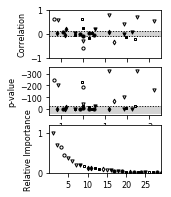

In [27]:
fig, axs = plt.subplots(3,1, figsize=(2,3))




domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

cmap = plt.cm.get_cmap('Reds')

max_feature_imp = np.nanmax(rnd_clf.feature_importances_)
markersize = 10
markersize2 = 7

fulllist = []

pvaluecutt = -25
corrcutt = 0.10
diffcutt = 2.5

end = np.zeros(4)

k = 0

sort_import = np.sort(rnd_clf.feature_importances_)[::-1]
argsort_import = np.argsort(rnd_clf.feature_importances_, )[::-1]
# print(data_final_vars[argsort_import])
print(sort_import)
print(argsort_import)

for l, arg in enumerate(argsort_import):
    print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])




rownames = sort.index[sort.index.isin(spatiallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
        if row == var:
            if (np.abs(sdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(sdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize, 
                             c='w', edgecolors = 'k', linewidth = 1)
                axs[1].scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp ,marker="o",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize, 
                             c='k', edgecolors = 'k', linewidth = 1)
                axs[1].scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp ,marker="o",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[0]=k

rownames = sort.index[sort.index.isin(morphlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if row == 'region_minaxis':
                pvalue = 10**(-320)
            if (np.abs(mdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(mdata_mode[i]) > diffcutt):
                fulllist.append(row)            
                axs[0].scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize,
                             c='w', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
                axs[1].scatter(mdata_mode[i],np.log10(pvalue), marker="v",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="v",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize,
                             c='k', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
                axs[1].scatter(mdata_mode[i],np.log10(pvalue), marker="v",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="v",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[1]=k

rownames = sort.index[sort.index.isin(temporallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(tdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(tdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(tdata_mode[i], tdata[i,0], marker="d",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)             
                axs[1].scatter(tdata_mode[i],np.log10(pvalue), marker="d",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="d",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(tdata_mode[i], tdata[i,0], marker="d",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)             
                axs[1].scatter(tdata_mode[i],np.log10(pvalue), marker="d",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="d",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[2]=k
                
rownames = sort.index[sort.index.isin(freqlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(fdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(fdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize2,
                            c='w', edgecolors = 'k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            linewidth = 1)
                axs[1].scatter(fdata_mode[i],np.log10(pvalue), marker="s",s=markersize2,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="s",s=markersize2,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize2,
                            c='k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            edgecolors = 'k', linewidth = 1)
                axs[1].scatter(fdata_mode[i],np.log10(pvalue), marker="s",s=markersize2,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="s",s=markersize2,
#                              c='k', edgecolors = 'k',linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[3]=k
                  
axs[0].set_ylabel('Correlation')
axs[0].set_ylim([-1,1])
axs[0].set_xticklabels([])
lims = axs[0].get_xlim()
axs[0].fill_between(lims, [corrcutt,corrcutt], [-corrcutt,-corrcutt], color = 'lightgrey', zorder=0)
axs[0].hlines(corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].hlines(-corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].set_xticks([-1,0,1,2,3])

axs[0].set_xlim(lims)

axs[1].hlines(pvaluecutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[1].set_ylabel('p-value')
axs[1].set_xlabel('Mode difference')
axs[1].fill_between(lims, [pvaluecutt,pvaluecutt], [axs[1].get_ylim()[1],axs[1].get_ylim()[1]], color = 'lightgrey', zorder=0)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_xticks([-1,0,1,2,3])
axs[1].set_xticklabels(['-1','','1','','3'])
axs[1].set_yticks([0,-100,-200,-300])
axs[1].set_xlim(lims)

# print(end)
# print((end[:-1] - end[1:])/2)
# tic = end + (end[:-1] - end[1:])/2
axs[2].set_xticks(np.arange(4,l,5))
axs[2].set_xticklabels(np.arange(5,l+1,5))

# axs[2].set_xticklabels(['spat.', 'morph.', 'temp.', 'freq.'])
print(l)
axs[2].set_xlim(-1,l)
axs[2].set_ylim(0,1.2)
axs[2].set_ylabel('Relative Importance')

# axs2.set_ylim([1, 800])
# fig.tight_layout()
fig.savefig('feature_scatter_mode_corr_notext.svg', dpi = 600)

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

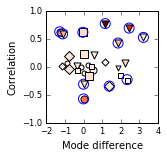

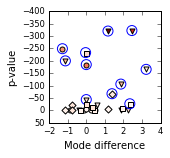

In [8]:
fig, axs1 = plt.subplots(1,1, figsize=(2,2))
fig2, axs2 = plt.subplots(1,1, figsize=(2,2))




domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

cmap = plt.cm.get_cmap('Reds')

max_feature_imp = np.nanmax(rnd_clf.feature_importances_)
markersize = 50
markersize2 = 25
markersize3 = 100

fulllist = []

pvaluecutt = -25
corrcutt = 0.10
diffcutt = 2.5

rownames = sort.index[sort.index.isin(spatiallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            if rfe.ranking_[j] == 1:
                axs1.scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize, 
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)

            else:
                axs1.scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize2,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            axs2.scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize2,
                         c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            if (np.abs(sdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(sdata_mode[i]) > diffcutt):
                fulllist.append(row)
#             if row in domain_vars:
                axs1.scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize3,
                             c='None', linewidth = 1, edgecolor = 'b')
                axs2.scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize3,
                         c='None', linewidth = 1, edgecolor = 'b')
            
#             else:
#                 axs1.text(sdata_mode[i], sdata[i,0], row)
#                 axs2.text(sdata_mode[i], np.log10(pvalue), row)

rownames = sort.index[sort.index.isin(morphlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            if rfe.ranking_[j] == 1:
                axs1.scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            else:
                axs1.scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize2,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if row == 'region_minaxis':
                pvalue = 10**(-320)
            axs2.scatter(mdata_mode[i],np.log10(pvalue), marker="v",s=markersize2,
                         c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            if (np.abs(mdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(mdata_mode[i]) > diffcutt):
                fulllist.append(row)
#             if row in domain_vars:
                axs1.scatter(mdata_mode[i], mdata[i,0], marker="o",s=markersize3,
                             c='None', linewidth = 1, edgecolor = 'b')
                axs2.scatter(mdata_mode[i], np.log10(pvalue), marker="o",s=markersize3,
                         c='None', linewidth = 1, edgecolor = 'b')
#             else:
#                 axs1.text(mdata_mode[i], mdata[i,0], row)
#                 axs2.text(mdata_mode[i], np.log10(pvalue), row)

rownames = sort.index[sort.index.isin(temporallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            if rfe.ranking_[j] == 1:
                axs1.scatter(tdata_mode[i], tdata[i,0], marker="D",s=markersize,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            else:
                axs1.scatter(tdata_mode[i], tdata[i,0], marker="D",s=markersize2,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)                  
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            axs2.scatter(tdata_mode[i],np.log10(pvalue), marker="D",s=markersize2,
                         c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            if (np.abs(tdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(tdata_mode[i]) > diffcutt):
                fulllist.append(row)
#             if row in domain_vars:
                axs1.scatter(tdata_mode[i], tdata[i,0], marker="o",s=markersize3,
                             c='None', linewidth = 1, edgecolor = 'b')
                axs2.scatter(tdata_mode[i], np.log10(pvalue), marker="o",s=markersize3,
                         c='None', linewidth = 1, edgecolor = 'b')
#             else:
#                 axs1.text(tdata_mode[i], tdata[i,0], row)
#                 axs2.text(tdata_mode[i], np.log10(pvalue), row)

rownames = sort.index[sort.index.isin(freqlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            if rfe.ranking_[j] == 1:
                axs1.scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize,
                             c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            else:
                axs1.scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize2,c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            axs2.scatter(fdata_mode[i],np.log10(pvalue), marker="s",s=markersize2,
                         c=cmap(rnd_clf.feature_importances_[j]/max_feature_imp), linewidth = 1)
            if (np.abs(fdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(fdata_mode[i]) > diffcutt):
                fulllist.append(row)
#             if row in domain_vars:
                axs1.scatter(fdata_mode[i], fdata[i,0], marker="o",s=markersize3,
                             c='None', linewidth = 1, edgecolor = 'b')
                axs2.scatter(fdata_mode[i], np.log10(pvalue), marker="o",s=markersize3,
                         c='None', linewidth = 1, edgecolor = 'b') 
#             else:             
#                 axs1.text(fdata_mode[i], fdata[i,0], row)                
#                 axs2.text(fdata_mode[i], np.log10(pvalue), row)                
                                                                          
                                                  
                            
axs1.set_ylabel('Correlation')
axs1.set_xlabel('Mode difference')

axs1.set_ylim([-1,1])

axs2.set_ylabel('p-value')
axs2.set_xlabel('Mode difference')
plt.gca().invert_yaxis()
# axs2.set_ylim([1, 800])
fig.savefig('0feature_scatter_mode_corr_notext.svg', dpi = 600)
fig2.savefig('0feature_scatter_mode_pvalue_notext.svg', dpi = 600)

plt.show()

In [178]:
print(domain_vars)
print(len(domain_vars))
print(fulllist)
print(len(fulllist))
# fulllist.remove('region_centroid_1')
for met in fulllist:
    if not met in domain_vars:
        print(met, 'missing from old')
        
        
for met in domain_vars:
    if not met in fulllist:
        print(met, 'missing from new')

['freq_range_high', 'freq_range_low', 'freq_rangesz', 'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area', 'threshold_perc', 'spatial_max', 'spatial_min', 'temporal_max', 'temporal_min', 'temporal_std']
15
['spatial_min', 'spatial_max', 'region_minaxis', 'threshold_area', 'region_extent', 'threshold_perc', 'region_majaxis', 'region_majmin_ratio', 'temporal_min', 'freq_rangesz', 'freq_maxsnr']
11
freq_maxsnr missing from old
freq_range_high missing from new
freq_range_low missing from new
region_eccentricity missing from new
temporal_max missing from new
temporal_std missing from new


# Colorbars for feature selection metrics


Index(['age', 'artifact', 'freq_avgsnr', 'freq_integrate', 'freq_maxsnr',
       'freq_maxsnr_freq', 'freq_range_high', 'freq_range_low', 'freq_rangesz',
       'length', 'mass_perc', 'mass_region', 'mass_total', 'region_centroid_0',
       'region_centroid_1', 'region_eccentricity', 'region_extent',
       'region_majaxis', 'region_majmin_ratio', 'region_minaxis',
       'region_orient', 'signal', 'spatial_COMall_x', 'spatial_COMall_y',
       'spatial_COMdom_x', 'spatial_COMdom_y', 'spatial_avg', 'spatial_max',
       'spatial_min', 'spatial_n_domains', 'spatial_std', 'temporal_autocorr',
       'temporal_max', 'temporal_min', 'temporal_n_freq', 'temporal_std',
       'threshold_area', 'threshold_perc', 'anml'],
      dtype='object')
[[-2.44538594e+02 -2.44538594e+02]
 [-1.28496677e+00 -1.28496677e+00]
 [-1.17922076e+00 -1.17922076e+00]
 [-1.37353106e-01 -1.37353106e-01]
 [-1.93867920e+00 -1.93867920e+00]
 [-8.12320805e+00 -8.12320805e+00]
 [-1.91322644e+02 -1.91322644e+02]]


<Figure size 800x800 with 0 Axes>

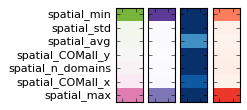

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log10


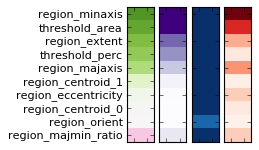

[[-20.50378439 -20.50378439]
 [ -3.97488874  -3.97488874]
 [ -0.13415663  -0.13415663]
 [ -1.14225917  -1.14225917]
 [-59.87301079 -59.87301079]]


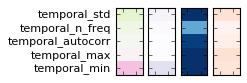

[[-232.97144675 -232.97144675]
 [ -25.9646513   -25.9646513 ]
 [  -0.5303805    -0.5303805 ]
 [  -2.50067403   -2.50067403]
 [ -10.38466945  -10.38466945]
 [ -13.06063572  -13.06063572]
 [ -26.44383426  -26.44383426]]


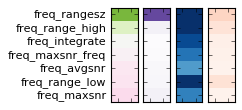

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

rownames = sort.index[sort.index.isin(spatiallist)]
fig, axs = plt.subplots(1,4, figsize=(2,.25 * len(rownames)))

axs[0].matshow(sdata, cmap = 'PiYG', vmin=-1, vmax=1)
axs[0].set_yticks(np.arange(len(rownames)))
axs[0].set_yticklabels(rownames)
axs[0].set_xticklabels([])

ttest = np.zeros_like(sdata)
for i, row in enumerate(rownames):
    tstat, pvalue = ttest_ind(data[row][data['artifact']==0], data[row][data['artifact']==1])
    ttest[i,:] = np.log10(pvalue)
print(ttest)
    
axs[1].matshow(ttest, cmap = 'Purples_r', vmin=-300, vmax=0)
axs[1].set_yticklabels([])
axs[1].set_xticklabels([]) 

rferank = np.zeros_like(sdata)
impor = np.zeros_like(sdata)
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            rferank[i,:] = rfe.ranking_[j]
            impor[i,:] = rnd_clf.feature_importances_[j]
            
axs[2].matshow(rferank, cmap = 'Blues_r', vmin=1, vmax=20)
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])             
            
axs[3].matshow(impor, cmap = 'Reds', vmin=0, vmax=.20)
axs[3].set_yticklabels([])
axs[3].set_xticklabels([])               
if save: 
    plt.savefig('spatial_metrics.svg', dpi = 600)
plt.show()

# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])
# if save: 
#     plt.savefig('spatial_metrics_nolabel.svg', dpi = 600)
# plt.show()


rownames = sort.index[sort.index.isin(morphlist)]
fig, axs = plt.subplots(1,4, figsize=(2,.25 * len(rownames)))

axs[0].matshow(mdata, cmap = 'PiYG', vmin=-1, vmax=1)
axs[0].set_yticks(np.arange(len(rownames)))
axs[0].set_yticklabels(rownames)
axs[0].set_xticklabels([])

ttest = np.zeros_like(mdata)
for i, row in enumerate(rownames):
    tstat, pvalue = ttest_ind(data[row][data['artifact']==0], data[row][data['artifact']==1])
    ttest[i,:] = np.log10(pvalue)
ttest[ttest==-np.inf] = -300
axs[1].matshow(ttest, cmap = 'Purples_r', vmin=-300, vmax=0)
axs[1].set_yticklabels([])
axs[1].set_xticklabels([]) 

rferank = np.zeros_like(mdata)
impor = np.zeros_like(mdata)
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            rferank[i,:] = rfe.ranking_[j]
            impor[i,:] = rnd_clf.feature_importances_[j]

axs[2].matshow(rferank, cmap = 'Blues_r', vmin=1, vmax=20)
axs[2].set_yticklabels([])
axs[2].set_xticklabels([]) 

axs[3].matshow(impor, cmap = 'Reds', vmin=0, vmax=.20)
axs[3].set_yticklabels([])
axs[3].set_xticklabels([])   
if save: 
    plt.savefig('morph_metrics.svg', dpi = 600)
plt.show()


# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])
# if save: 
#     plt.savefig('morph_metrics_nolabel.svg', dpi = 600)
# plt.show()

rownames = sort.index[sort.index.isin(temporallist)]
fig, axs = plt.subplots(1,4, figsize=(2,.25 * len(rownames)))

axs[0].matshow(tdata, cmap = 'PiYG', vmin=-1, vmax=1)
axs[0].set_yticks(np.arange(len(rownames)))
axs[0].set_yticklabels(rownames)
axs[0].set_xticklabels([])

ttest = np.zeros_like(tdata)
for i, row in enumerate(rownames):
    tstat, pvalue = ttest_ind(data[row][data['artifact']==0], data[row][data['artifact']==1])
    ttest[i,:] = np.log10(pvalue)
print(ttest)
  
axs[1].matshow(ttest, cmap = 'Purples_r', vmin=-300, vmax=0)
axs[1].set_yticklabels([])
axs[1].set_xticklabels([]) 

rferank = np.zeros_like(tdata)
impor = np.zeros_like(tdata)
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            rferank[i,:] = rfe.ranking_[j]
            impor[i,:] = rnd_clf.feature_importances_[j]

axs[2].matshow(rferank, cmap = 'Blues_r', vmin=1, vmax=20)
axs[2].set_yticklabels([])
axs[2].set_xticklabels([]) 

axs[3].matshow(impor, cmap = 'Reds', vmin=0, vmax=.20)
axs[3].set_yticklabels([])
axs[3].set_xticklabels([])   
if save: 
    plt.savefig('temporal_metrics.svg', dpi = 600)
plt.show()

# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])
# if save: 
#     plt.savefig('temporal_metrics_nolabel.svg', dpi = 600)
# plt.show()

rownames = sort.index[sort.index.isin(freqlist)]
fig, axs = plt.subplots(1,4, figsize=(2,.25 * len(rownames)))

im1 = axs[0].matshow(fdata, cmap = 'PiYG', vmin=-1, vmax=1)
axs[0].set_yticks(np.arange(len(rownames)))
axs[0].set_yticklabels(rownames)
axs[0].set_xticklabels([])

ttest = np.zeros_like(fdata)
for i, row in enumerate(rownames):
    tstat, pvalue = ttest_ind(data[row][data['artifact']==0], data[row][data['artifact']==1])
    ttest[i,:] = np.log10(pvalue)
print(ttest)
    
axs[1].matshow(ttest, cmap = 'Purples_r', vmin=-300, vmax=0)
axs[1].set_yticklabels([])
axs[1].set_xticklabels([]) 

rferank = np.zeros_like(fdata)
impor = np.zeros_like(fdata)
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            rferank[i,:] = rfe.ranking_[j]
            impor[i,:] = rnd_clf.feature_importances_[j]

axs[2].matshow(rferank, cmap = 'Blues_r', vmin=1, vmax=20)
axs[2].set_yticklabels([])
axs[2].set_xticklabels([]) 

axs[3].matshow(impor, cmap = 'Reds', vmin=0, vmax=.20)
axs[3].set_yticklabels([])
axs[3].set_xticklabels([])   

if save: 
    plt.savefig('freq_metrics.svg', dpi = 600)
# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])
# if save: 
#     plt.savefig('freq_metrics_nolabel.svg', dpi = 600)
# plt.show()

# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

plt.show()



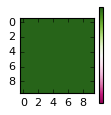

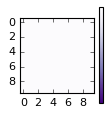

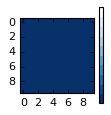

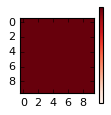

In [65]:
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('PiYG'), alpha =1, 
           vmin = -1, vmax = 1)
cbr = plt.colorbar()
cbr.set_ticks([])
plt.savefig('correlation_colorbar.svg', dpi = 600)
plt.show()

fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('Purples_r'), alpha =1, 
           vmin = -300, vmax = 0)
cbr = plt.colorbar()
cbr.set_ticks([])
plt.savefig('pvalue_colorbar.svg', dpi = 600)
plt.show()

fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('Blues_r', 10), alpha =1, 
           vmin = 1, vmax = 10)
cbr = plt.colorbar()
cbr.set_ticks([])
plt.savefig('RFE_colorbar.svg', dpi = 600)
plt.show()

fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('Reds'), alpha =1, 
           vmin = 0, vmax = 0.3)
cbr = plt.colorbar()
cbr.set_ticks([])
plt.savefig('Importance_colorbar.svg', dpi = 600)
plt.show()

# Covariance matrices for all metrics


In [18]:
from scipy.stats import ttest_ind

#     model.t_test_pairwise('C('+row+')').result_frame

-232.97144674887676
-25.96465130484935
-0.5303805029476236
-2.5006740264862812
-10.38466945386803
-13.06063571722383
-26.44383425513075


Index(['age', 'artifact', 'freq_avgsnr', 'freq_integrate', 'freq_maxsnr',
       'freq_maxsnr_freq', 'freq_range_high', 'freq_range_low', 'freq_rangesz',
       'length', 'mass_perc', 'mass_region', 'mass_total', 'region_centroid_0',
       'region_centroid_1', 'region_eccentricity', 'region_extent',
       'region_majaxis', 'region_majmin_ratio', 'region_minaxis',
       'region_orient', 'signal', 'spatial_COMall_x', 'spatial_COMall_y',
       'spatial_COMdom_x', 'spatial_COMdom_y', 'spatial_avg', 'spatial_max',
       'spatial_min', 'spatial_n_domains', 'spatial_std', 'temporal_autocorr',
       'temporal_max', 'temporal_min', 'temporal_n_freq', 'temporal_std',
       'threshold_area', 'threshold_perc', 'anml'],
      dtype='object')


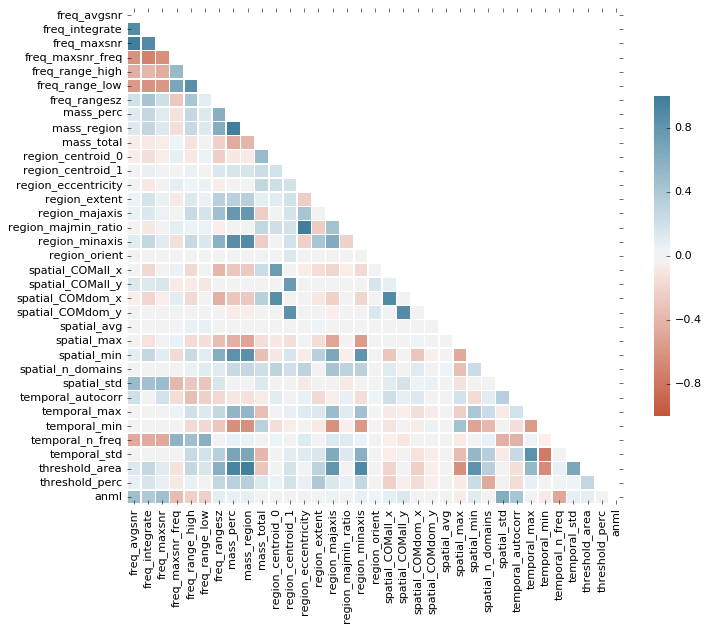

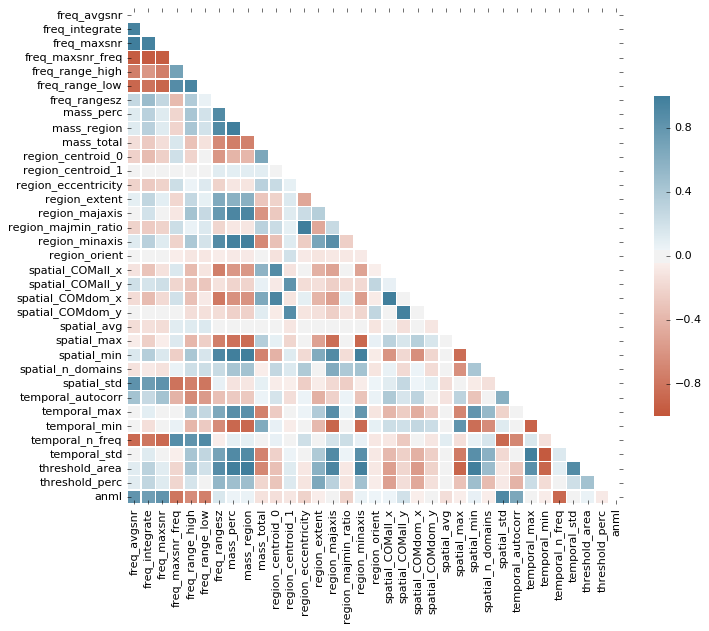

In [17]:
fig = plt.figure( figsize = (10,10), constrained_layout=False)

droplist = ['age', 'artifact', 'length', 'signal']
print(data.columns)
dcorr = data.drop(droplist, axis=1)

dcorr = dcorr.corr('spearman')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))
# mask = np.zeros_like(dcorr, dtype=np.bool)


pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()

dcorr = dcorr.corr('pearson')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))
# mask = np.zeros_like(dcorr, dtype=np.bool)


fig = plt.figure( figsize = (10,10), constrained_layout=False)

pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()

# PCA projected data with metric mapping

In [179]:
#creating appropriate datasets
# ---------------------------------------------------------



domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

data = data.fillna(value=0).copy()
dataAll = data[fulllist].copy()

# dataNoThresh = data[data['threshold.area'] == 0].copy()
# dataNoThresh = dataNoThresh[nodomain_vars].fillna(value=0).copy()

# dataThresh = data[data['threshold.area'] != 0].copy()
# dataThresh = dataThresh[domain_vars].fillna(value=0).copy()

for col in fulllist:
    dataAll[col] = (data[col] - np.mean(data[col])) / (np.std(data[col], ddof=1)) 
# for col in domain_vars:
#     dataThresh[col] = (dataThresh[col] - np.mean(dataThresh[col])) / (np.std(dataThresh[col], ddof=1)) 
# for col in nodomain_vars:
#     dataNoThresh[col] = (dataNoThresh[col] - np.mean(dataNoThresh[col])) / (np.std(dataNoThresh[col], ddof=1))
    
# print(len(dataThresh))
# print(len(dataNoThresh))

In [180]:
#Plotting TruncatedSVD Plot
# ---------------------------------------------------------
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)

# X_reduced_SVD = svd.fit_transform(dataThresh.values)

# X_reduced_SVD2 = svd.fit_transform(dataNoThresh.values)

X_reduced_SVD3 = svd.fit_transform(dataAll.values)


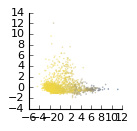

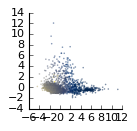

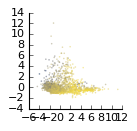

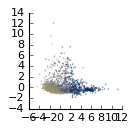

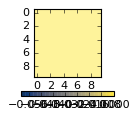

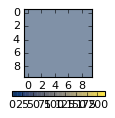

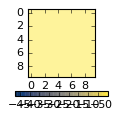

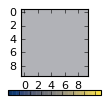

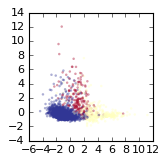

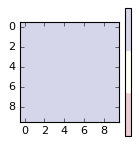

In [181]:
fig, axs = plt.subplots(1, 1, figsize = (1.5,1.5), sharex=True, sharey = True)
plt.subplots_adjust(wspace = 0.3)
axs.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'spatial_min'], 
            cmap=plt.cm.get_cmap('cividis'), edgecolors='none', s = 2, alpha = 0.5)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
if save: 
    plt.savefig('SVD_plots_all_21_A.png', dpi = 600)
plt.show()
fig, axs = plt.subplots(1, 1, figsize = (1.5,1.5), sharex=True, sharey = True)
axs.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'region_minaxis'], 
            cmap=plt.cm.get_cmap('cividis'), edgecolors='none', s = 2, alpha = 0.5)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
if save: 
    plt.savefig('SVD_plots_all_21_B.png', dpi = 600)
plt.show()

# fig, axs = plt.subplots(2, 1, figsize = (1.5,3), sharex=True, sharey = True)
fig, axs = plt.subplots(1, 1, figsize = (1.5,1.5), sharex=True, sharey = True)
axs.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'temporal_min'], 
            cmap=plt.cm.get_cmap('cividis'), edgecolors='none', s = 2, alpha = 0.5)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
if save: 
    plt.savefig('SVD_plots_all_21_C.png', dpi = 600)
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (1.5,1.5), sharex=True, sharey = True)
axs.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'freq_rangesz'], 
            cmap=plt.cm.get_cmap('cividis'), edgecolors='none', s = 2, alpha = 0.5)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
if save: 
    plt.savefig('SVD_plots_all_21_D.png', dpi = 600)
plt.show()





fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('cividis'), alpha = 0.5, 
           vmin = data['spatial_min'].min(), vmax = data['spatial_min'].max())
plt.colorbar(orientation="horizontal")
plt.savefig('spatial_min_colorbar.svg', dpi = 600)
plt.show()
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('cividis'), alpha = 0.5, 
           vmin = data['region_minaxis'].min(), vmax = data['region_minaxis'].max())
plt.colorbar(orientation="horizontal")
plt.savefig('region_minaxis_colorbar.svg', dpi = 600)
plt.show()
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('cividis'), alpha = 0.5, 
           vmin = data['temporal_min'].min(), vmax = data['temporal_min'].max())
plt.colorbar(orientation="horizontal")
plt.savefig('temporal_min_colorbar.svg', dpi = 600)
plt.show()
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('cividis'), alpha = 0.5, 
           vmin = data['freq_rangesz'].min(), vmax = data['freq_rangesz'].max())
cbar = plt.colorbar(orientation="horizontal")
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=60)
plt.savefig('freq_rangesz_colorbar.svg', dpi = 600)
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (2,2), sharex=True, sharey = True)




data.loc[data['signal']==1,'class']=0
data.loc[data['movement']==1, 'class']=1
data.loc[data['hemodynamic']==1, 'class']=2

axs.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'class'], 
            cmap=plt.cm.get_cmap('RdYlBu_r',3), edgecolors='none', s = 5, alpha = 0.4)
if save: 
    plt.savefig('SVD_plots_all_s_a.png', dpi = 600)
plt.show()




fig = plt.figure(figsize=(2,2))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('RdYlBu',3), alpha = 0.2, 
           vmin =0, vmax =1)
cbr = plt.colorbar()
cbr.set_ticks([])
plt.savefig('signal_artifact_colorbar.svg', dpi = 600)
plt.show()



# fig = plt.figure(figsize = (4,2.5), constrained_layout=False)

# gs = fig.add_gridspec(1, 2)
# gs.update(wspace = 0.15, hspace = 0.5)


# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])

# fig.text(0.08, 0.5, 'SVD1', ha='center',rotation='vertical')
# fig.text(0.5, 0.01, 'SVD2', ha='center')

# ph1 = ax1.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], c=data.loc[dataThresh.index, 'signal'], 
#             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
# ax1.set_title('Subset 1')

# ax2.set_title('Subset 2')
# ph2 = ax2.scatter(X_reduced_SVD2[:, 0], X_reduced_SVD2[:, 1], c=data.loc[dataNoThresh.index, 'signal'], 
#             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)

# if save: 
#     plt.savefig('SVD_plots_subsets.svg', dpi = 600)
# plt.show()

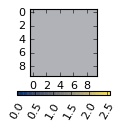

In [114]:
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.ones((10,10)), cmap=plt.cm.get_cmap('cividis'), alpha = 0.5, 
           vmin = data['freq_rangesz'].min(), vmax = data['freq_rangesz'].max())
cbar = plt.colorbar(orientation="horizontal", ticks=np.arange(data['freq_rangesz'].min(), data['freq_rangesz'].max(), 0.5))
cbar.ax.set_xticklabels(np.arange(data['freq_rangesz'].min(), data['freq_rangesz'].max(), 0.5), rotation=60)
plt.show()


/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


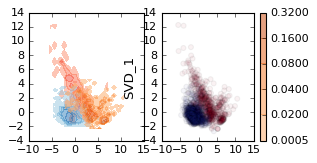

In [101]:
import matplotlib

fig = plt.figure(figsize = (4,2), constrained_layout=False)

gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.15, hspace = 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# ax0.scatter(X_reduced_SVD3[:, 0], X_reduced_SVD3[:, 1], c=data.loc[dataAll.index, 'signal'], 
#             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
# ax0.set_ylabel('SVD_1')

levels = [0.0005, .02,.04,.08,.16,.32]
redcolor = matplotlib.cm.get_cmap('Reds')
bluecolor = matplotlib.cm.get_cmap('Blues')
yellowcolor = matplotlib.cm.get_cmap('Oranges')

blu = [bluecolor(100), bluecolor(125), bluecolor(150),bluecolor(175),bluecolor(200),bluecolor(255)]
red = [redcolor(100), redcolor(125), redcolor(150),redcolor(175),redcolor(200),redcolor(255)]
yel = [yellowcolor(100),yellowcolor(125), yellowcolor(150),yellowcolor(175),yellowcolor(200),yellowcolor(255)]

ph1 = ax1.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'artifact'], 
            cmap=plt.cm.get_cmap('RdYlBu_r',2), s = 20, alpha = 0.05)
ax1.set_ylabel('SVD_1')

counts,ybins,xbins = np.histogram2d(X_reduced_SVD3[:, 1][data['class']==2],
                                    X_reduced_SVD3[:, 0][data['class']==2], bins=25, normed=True)
CS0 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=red, alpha=0.5)

counts,ybins,xbins = np.histogram2d(X_reduced_SVD3[:, 1][data['class']==0],
                                    X_reduced_SVD3[:, 0][data['class']==0],bins=25, normed=True)

CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=blu, alpha=0.5)

counts,ybins,xbins = np.histogram2d(X_reduced_SVD3[:, 1][data['class']==1],
                                    X_reduced_SVD3[:, 0][data['class']==1],bins=25, normed=True)

CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=yel, alpha=0.5)

ax0.set_ylim(-4,14)
ax0.set_xlim(-10,15)

# cbar = fig.colorbar(CS0)
# cbar.ax.set_ylabel('verbosity coefficient')
# # Add the contour line levels to the colorbar
# cbar.add_lines(CS0)

cbar2 = fig.colorbar(CS1)
# Add the contour line levels to the colorbar
# cbar2.add_lines(CS1)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar2 = fig.colorbar(ph1, ticks=[], cax=cax, orientation='vertical')
# cbar2.ax.set_yticklabels(['Artifact', 'Signal'], rotation = 90)
# cbar2.ax.yaxis.set_ticks_position('left')
# cbar2.ax.tick_params(size=0)
# cbar2.ax.axis('off')


if save: 
    plt.savefig('SVD_plots_all.svg', dpi = 600)
plt.show()


# fig = plt.figure(figsize = (4,2.5), constrained_layout=False)

# gs = fig.add_gridspec(1, 2)
# gs.update(wspace = 0.15, hspace = 0.5)


# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])

# fig.text(0.08, 0.5, 'SVD1', ha='center',rotation='vertical')
# fig.text(0.5, 0.01, 'SVD2', ha='center')

# ph1 = ax2.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], c=data.loc[dataThresh.index, 'signal'], 
#             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
# # ax2.set_title('Subset 1')



# counts,ybins,xbins = np.histogram2d(X_reduced_SVD[:, 1][data.loc[dataThresh.index, 'artifact']==1], 
#                                     X_reduced_SVD[:, 0][data.loc[dataThresh.index, 'artifact']==1],
#                                     bins=30, normed=True)
# CS0 = ax1.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
#             linewidths=3, levels=levels, colors=red, alpha=0.5)

# counts,ybins,xbins = np.histogram2d(X_reduced_SVD[:, 1][data.loc[dataThresh.index, 'artifact']==0],
#                                     X_reduced_SVD[:, 0][data.loc[dataThresh.index, 'artifact']==0],
#                                     bins=30, normed=True)
# CS1 = ax1.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
#             linewidths=3, levels=levels, colors=blu, alpha=0.5)


# # cbar = fig.colorbar(CS0)
# # # cbar.ax.set_ylabel('verbosity coefficient')
# # # # Add the contour line levels to the colorbar
# # cbar.add_lines(CS0)

# # cbar2 = fig.colorbar(CS1)
# # cbar2.add_lines(CS1)



# ax1.set_xlim(-6,12)
# ax1.set_ylim(-10,15)

# # ax2.set_title('Subset 2')
# # ph2 = ax2.scatter(X_reduced_SVD2[:, 0], X_reduced_SVD2[:, 1], c=data.loc[dataNoThresh.index, 'signal'], 
# #             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)

# if save: 
#     plt.savefig('contour_SVD_plots_subset1.png', dpi = 300)
# plt.show()

# plt.show()

# ---------------------------------------------------------

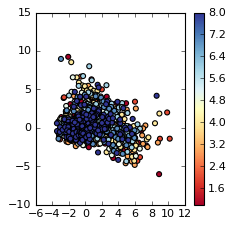

In [13]:
plt.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], c=data.loc[dataThresh.index, 'anml'], 
            cmap=plt.cm.get_cmap('RdYlBu'), s = 20, alpha = 1)
plt.colorbar()
plt.show()